In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>")) #makes the display bars longer and spread out 100% across the screen width

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 8)

#import xarray as xr
import warnings
warnings.filterwarnings('ignore')
from matplotlib.backends.backend_pdf import PdfPages

!pwd
!whoami
!date

/ihme/homes/ndbs/vivarium_research_ciff/nathaniel/model_validation/model2
ndbs
Fri Jul 23 16:51:53 PDT 2021


# 2.1: WASTING (RISK validation)

## wasting risk vv

In [3]:
%cd /ihme/costeffectiveness/results/vivarium_ciff_sam/v2.1_gbd_2020_wasting_data/ciff_sam/2021_07_20_10_32_31/count_data
%ls

/ihme/costeffectiveness/results/vivarium_ciff_sam/v2.1_gbd_2020_wasting_data/ciff_sam/2021_07_20_10_32_31/count_data
deaths.csv                     population.csv                 ylds.csv
deaths.hdf                     population.hdf                 ylds.hdf
disease_state_person_time.csv  wasting_state_person_time.csv  ylls.csv
disease_state_person_time.hdf  wasting_state_person_time.hdf  ylls.hdf
disease_transition_count.csv   wasting_transition_count.csv
disease_transition_count.hdf   wasting_transition_count.hdf


In [4]:
# master_dir = '/home/j/Project/simulation_science/ciff_malnutrition/'
master_dir = '/share/scratch/users/ndbs/vivarium_results/ciff_malnutrition/'
sim_result_dir = '/ihme/costeffectiveness/results/vivarium_ciff_sam/v2.1_gbd_2020_wasting_data/ciff_sam/2021_07_20_10_32_31/count_data/'
output_dir = master_dir + f'verification_and_validation/v2.1_gbd_2020_wasting/'


## LOAD SIM DATA

In [5]:
def load_sim_count_data(sim_result_dir: str):
    columns = ['age', 'sex', 'year', 'input_draw', 'scenario', 'measure']
    df = {}
    fnames = ['deaths', 'disease_transition_count', 'wasting_transition_count',
              'disease_state_person_time', 'wasting_state_person_time']
    for fname in fnames:
        df[fname] = pd.read_csv(sim_result_dir + fname + '.csv', index_col=0)
        # get aggregated results if stratifications exist
        if 'cause' in df[fname].columns:
            df[fname] = df[fname].groupby(columns + ['cause']).value.sum().reset_index()
        else:
            df[fname] = df[fname].groupby(columns).value.sum().reset_index()
    return df

df = load_sim_count_data(sim_result_dir)

In [6]:
pd.read_csv(sim_result_dir + 'wasting_transition_count.csv', index_col=0).query('measure == "susceptible_to_child_wasting_to_mild_child_wasting_event_count"')

,sex,year,measure,input_draw,scenario,value,age
432,female,2022,susceptible_to_child_wasting_to_mild_child_was...,29,baseline,27.0,early_neonatal
433,female,2022,susceptible_to_child_wasting_to_mild_child_was...,29,baseline,102.0,late_neonatal
434,female,2022,susceptible_to_child_wasting_to_mild_child_was...,29,baseline,1396.0,1-5_months
435,female,2022,susceptible_to_child_wasting_to_mild_child_was...,29,baseline,3069.0,6-11_months
...,...,...,...,...,...,...,...
5036,male,2026,susceptible_to_child_wasting_to_mild_child_was...,946,baseline,705.0,1-5_months
5037,male,2026,susceptible_to_child_wasting_to_mild_child_was...,946,baseline,952.0,6-11_months
5038,male,2026,susceptible_to_child_wasting_to_mild_child_was...,946,baseline,1707.0,12_to_23_months
5039,male,2026,susceptible_to_child_wasting_to_mild_child_was...,946,baseline,7302.0,2_to_4


In [7]:
results = pd.read_csv(sim_result_dir + 'wasting_transition_count.csv', index_col=0)
incidence_mild_count = results.query('measure == "susceptible_to_child_wasting_to_mild_child_wasting_event_count"')
incidence_mild_count.head()

,sex,year,measure,input_draw,scenario,value,age
432,female,2022,susceptible_to_child_wasting_to_mild_child_was...,29,baseline,27.0,early_neonatal
433,female,2022,susceptible_to_child_wasting_to_mild_child_was...,29,baseline,102.0,late_neonatal
434,female,2022,susceptible_to_child_wasting_to_mild_child_was...,29,baseline,1396.0,1-5_months
435,female,2022,susceptible_to_child_wasting_to_mild_child_was...,29,baseline,3069.0,6-11_months
436,female,2022,susceptible_to_child_wasting_to_mild_child_was...,29,baseline,7423.0,12_to_23_months


In [8]:
incidence_mild_count \
.groupby(['year','age']) \
.sum().drop(columns='input_draw').reset_index().set_index(['age']) \
.pivot(columns = 'year')

value                                        
year                 2022      2023      2024      2025      2026
age                                                              
1-5_months        35975.0   18072.0   18261.0   18073.0   17744.0
12_to_23_months  193022.0  118354.0   39748.0   39123.0   39644.0
2_to_4           520044.0  523481.0  458014.0  314706.0  169723.0
6-11_months       78820.0   21067.0   21141.0   20945.0   21139.0
early_neonatal      776.0     750.0     738.0     757.0     782.0
late_neonatal      2492.0    2224.0    2146.0    2186.0    2156.0

### WASTING STATE TRANSITION COUNTS

In [9]:
incidence_mild_count = (df['wasting_transition_count'].query('measure == "susceptible_to_child_wasting_to_mild_child_wasting_event_count"'))
incidence_mild_count['risk'] = 'mild_wasting'
incidence_mild_count['measure'] = 'incidence'

incidence_mam_count = (df['wasting_transition_count'].query('measure == "mild_child_wasting_to_moderate_acute_malnutrition_event_count"'))
incidence_mam_count['risk'] = 'mam'
incidence_mam_count['measure'] = 'incidence'

incidence_sam_count = (df['wasting_transition_count'].query('measure == "moderate_acute_malnutrition_to_severe_acute_malnutrition_event_count"'))
incidence_sam_count['risk'] = 'sam'
incidence_sam_count['measure'] = 'incidence'

remission_sam_count = (df['wasting_transition_count'].query('measure == "severe_acute_malnutrition_to_moderate_acute_malnutrition_event_count"'))
remission_sam_count['risk'] = 'sam'
remission_sam_count['measure'] = 'remission'

remission_mam_count = (df['wasting_transition_count'].query('measure == "moderate_acute_malnutrition_to_mild_child_wasting_event_count"'))
remission_mam_count['risk'] = 'mam'
remission_mam_count['measure'] = 'remission'

remission_mild_count = (df['wasting_transition_count'].query('measure == "mild_child_wasting_to_susceptible_to_child_wasting_event_count"'))
remission_mild_count['risk'] = 'mild_wasting'
remission_mild_count['measure'] = 'remission'

### WASTING STATE PERSON TIME

In [10]:
person_time_sus_wasting = df['wasting_state_person_time'].query('cause == "susceptible_to_child_wasting"')
person_time_mild_wasting = df['wasting_state_person_time'].query('cause == "mild_child_wasting"')
person_time_mam = df['wasting_state_person_time'].query('cause == "moderate_acute_malnutrition"')
person_time_sam = df['wasting_state_person_time'].query('cause == "severe_acute_malnutrition"')

#### TOTAL PERSON TIME

In [11]:
df['disease_person_time'] = df['disease_state_person_time'].loc[
    df['disease_state_person_time'].cause.isin(['diarrheal_diseases','susceptible_to_diarrheal_diseases'])
].groupby(['age','sex','year','input_draw','scenario','measure']).sum().reset_index()

df['disease_person_time']['cause'] = 'all_causes'

In [12]:
df['disease_state_person_time'].loc[
    df['disease_state_person_time'].cause.isin(['diarrheal_diseases','susceptible_to_diarrheal_diseases'])].value.sum()

22181521.935660504

In [13]:
df['risk_person_time'] = df['wasting_state_person_time'].groupby(['age','sex','year','input_draw','scenario','measure']).sum().reset_index()
df['risk_person_time']['cause'] = 'all_causes'

In [14]:
# i think the disease person time v risk person time should be equal
df['disease_person_time'].value.sum()

22181521.935660504

In [15]:
df['risk_person_time'].value.sum()

35226406.678987

## CALCULATE SIM MEASURES

In [16]:
def get_measure(data: pd.DataFrame, denom: pd.DataFrame, entity: str):
    """
    rate per PY among source population
    note the numerator is 'data' and denominator is df['person_time']
    """
    
    result = ((data
               .set_index(['age', 'sex', 'year', 'input_draw', 'scenario', 'measure', entity])
               .div(denom.drop(columns=['measure', 'cause'])
                    .set_index(['age', 'sex', 'year', 'input_draw', 'scenario'])))
              .reset_index())
    
    result['age_group'] = np.where(result['age'] == 'early_neonatal', 1,
                              np.where(result['age'] == 'late_neonatal', 2,
                                       np.where(result['age'] == '1-5_months',3,
                                                np.where(result['age'] == '6-11_months',4,
                                                         np.where(result['age'] == '12_to_23_months',5,
                                                         6)))))
    
    result_summary = (result
                      .groupby(['age_group', 'sex', 'year', 'scenario', 'measure', entity])
                      .value.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())
    
    return result_summary

In [17]:
df.keys()

dict_keys(['deaths', 'disease_transition_count', 'wasting_transition_count', 'disease_state_person_time', 'wasting_state_person_time', 'disease_person_time', 'risk_person_time'])

### PREVALENCE

In [18]:
# risk prevalence
prevalence_wasting_tmrel = get_measure(person_time_sus_wasting, df['risk_person_time'], 'cause')
prevalence_mild = get_measure(person_time_mild_wasting, df['risk_person_time'], 'cause')
prevalence_mam = get_measure(person_time_mam, df['risk_person_time'], 'cause')
prevalence_sam = get_measure(person_time_sam, df['risk_person_time'], 'cause')

### INCIDENCE

In [19]:
incidence_mild = get_measure(incidence_mild_count, denom = person_time_sus_wasting, entity = 'risk')
incidence_mam = get_measure(incidence_mam_count, denom = person_time_mild_wasting, entity = 'risk')
incidence_sam = get_measure(incidence_sam_count, denom = person_time_mam, entity = 'risk')

### REMISSION

In [20]:
remission_mild = get_measure(remission_mild_count, denom = person_time_mild_wasting, entity = 'risk')
remission_mam = get_measure(remission_mam_count, denom = person_time_mam, entity = 'risk')
remission_sam = get_measure(remission_sam_count, denom = person_time_sam, entity = 'risk')

# ARTIFACT

In [21]:
#filepath

%cd /ihme/costeffectiveness/artifacts/vivarium_ciff_sam/
%ls

/ihme/costeffectiveness/artifacts/vivarium_ciff_sam
backup-2.hdf  backup.hdf  ethiopia.hdf


In [22]:
from vivarium import Artifact

#explore the artifact data (note age groups)
art = Artifact('/ihme/costeffectiveness/artifacts/vivarium_ciff_sam/ethiopia.hdf', filter_terms=['year_start == 2019', 'age_start >=  0.076712', f'age_end <= 5'])

In [23]:
#load population structure

art_pop = art.load('population.structure').reset_index()

In [44]:
art_pop

,location,sex,age_start,age_end,year_start,year_end,value
0,Ethiopia,Female,0.076712,1.0,2019,2020,1.573806e+06
1,Ethiopia,Female,1.000000,5.0,2019,2020,6.437387e+06
2,Ethiopia,Male,0.076712,1.0,2019,2020,1.651227e+06
3,Ethiopia,Male,1.000000,5.0,2019,2020,6.742224e+06


In [24]:
def load_wasting_prev(cat):
    data = art.load('risk_factor.child_wasting.exposure')
    
    data = data.apply(pd.DataFrame.describe, percentiles=[0.025, 0.975], axis=1).filter(['mean', '2.5%', '97.5%']).reset_index()

    data['age'] = 0
    
    data['age'] = np.where(data['age_start'] == 0, 'early_neonatal', #1
                                            np.where(data['age_end'] == 0.5, '1-5_months', #3
                                                     np.where(data['age_start'] == 0.5, '6-11_months', #4
                                                              np.where(data['age_start'] == 1, '12_to_23_months',  #5
                                                                       np.where(data['age_start'] == 2, '2_to_4',       #6
                                                                       'late_neonatal'))))) #2
        
    data['age_group'] = np.where(data['age'] == 'early_neonatal', 1,
                                   np.where(data['age'] == 'late_neonatal', 2,
                                            np.where(data['age'] == '1-5_months', 3, 
                                                     np.where(data['age'] == '6-11_months', 4, 
                                                              np.where(data['age'] == '12_to_23_months', 5,
                                    6)))))


    data['sex'] = np.where(data['sex'] == 'Female', 'female', 'male')
    
    #subset to cat
    risk_dict = {
        'cat1':'sam',
        'cat2':'mam',
        'cat3':'mild_wasting',
        'cat4':'tmrel_wasting'
    }
    data['risk'] = data.parameter.map(risk_dict)
    data = data.loc[data.parameter==cat].drop(columns=['parameter'])
    data['measure'] = 'prevalence'
    
    return data

In [25]:
sam_prev = load_wasting_prev('cat1')
mam_prev = load_wasting_prev('cat2')
mild_prev = load_wasting_prev('cat3')
sus_wasting_prev = load_wasting_prev('cat4')

In [39]:
sam_prev

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,age,age_group,risk,measure
0,female,0.076712,0.5,2019,2020,0.024987,0.021183,0.028627,1-5_months,3,sam,prevalence
4,female,0.500000,1.0,2019,2020,0.025921,0.022489,0.029991,6-11_months,4,sam,prevalence
8,female,1.000000,2.0,2019,2020,0.017526,0.014464,0.020893,12_to_23_months,5,sam,prevalence
12,female,2.000000,5.0,2019,2020,0.010374,0.008191,0.012737,2_to_4,6,sam,prevalence
16,male,0.076712,0.5,2019,2020,0.040833,0.035179,0.046745,1-5_months,3,sam,prevalence
20,male,0.500000,1.0,2019,2020,0.038799,0.033571,0.044388,6-11_months,4,sam,prevalence
24,male,1.000000,2.0,2019,2020,0.028636,0.024285,0.032975,12_to_23_months,5,sam,prevalence
28,male,2.000000,5.0,2019,2020,0.016175,0.013549,0.018823,2_to_4,6,sam,prevalence


In [45]:
sam_prev.year_start.unique()

array([2019])

In [43]:
data = art.load('risk_factor.child_wasting.exposure')
data

draw_0    draw_1  \
sex    age_start age_end year_start year_end parameter                       
Female 0.076712  0.5     2019       2020     cat1       0.026143  0.027956   
                                             cat2       0.085194  0.086920   
                                             cat3       0.204788  0.203312   
                                             cat4       0.683875  0.681812   
...                                                          ...       ...   
Male   2.000000  5.0     2019       2020     cat1       0.018393  0.016716   
                                             cat2       0.078225  0.075297   
                                             cat3       0.212657  0.209826   
                                             cat4       0.690724  0.698160   

                                                          draw_2    draw_3  \
sex    age_start age_end year_start year_end parameter                       
Female 0.076712  0.5     2019       2020     cat1       0.022469  0.022621   
                                             cat2       0.080438  0.080538   
                                             cat3       0.201098  0.203368   
                                             cat4       0.695995  0.693473   
...                                                          ...       ...   
Male   2.000000  5.0     2019       2020     cat1       0.015746  0.016250   
                                             cat2       0.073713  0.073600   
                                             cat3       0.210035  0.207364   
                                             cat4       0.700506  0.702787   

                                                          draw_4    draw_5  \
sex    age_start age_end year_start year_end parameter                       
Female 0.076712  0.5     2019       2020     cat1       0.024626  0.022796   
                                             cat2       0.083067  0.082130   
                                             cat3       0.202225  0.207378   
                                             cat4       0.690081  0.687696   
...                                                          ...       ...   
Male   2.000000  5.0     2019       2020     cat1       0.013366  0.017258   
                                             cat2       0.070075  0.075379   
                                             cat3       0.212434  0.209071   
                                             cat4       0.704125  0.698292   

                                                          draw_6    draw_7  \
sex    age_start age_end year_start year_end parameter                       
Female 0.076712  0.5     2019       2020     cat1       0.026173  0.023676   
                                             cat2       0.086013  0.082505   
                                             cat3       0.206429  0.204988   
                                             cat4       0.681385  0.688831   
...                                                          ...       ...   
Male   2.000000  5.0     2019       2020     cat1       0.015111  0.013541   
                                             cat2       0.074453  0.071795   
                                             cat3       0.214033  0.215055   
                                             cat4       0.696403  0.699609   

                                                          draw_8    draw_9  \
sex    age_start age_end year_start year_end parameter                       
Female 0.076712  0.5     2019       2020     cat1       0.023944  0.024448   
                                             cat2       0.082322  0.082950   
                                             cat3       0.202663  0.203603   
                                             cat4       0.691071  0.689000   
...                                                          ...       ...   
Male   2.000000  5.0     2019       2020     cat1       0.016064  0.015126  

In [55]:
def load_all_wasting_prev():
    data = art.load('risk_factor.child_wasting.exposure')
    
    data = data.apply(pd.DataFrame.describe, percentiles=[0.025, 0.975], axis=1).filter(['mean', '2.5%', '97.5%']).reset_index()

    data['age'] = 0
    
    data['age'] = np.where(data['age_start'] == 0, 'early_neonatal', #1
                                            np.where(data['age_end'] == 0.5, '1-5_months', #3
                                                     np.where(data['age_start'] == 0.5, '6-11_months', #4
                                                              np.where(data['age_start'] == 1, '12_to_23_months',  #5
                                                                       np.where(data['age_start'] == 2, '2_to_4',       #6
                                                                       'late_neonatal'))))) #2
        
    data['age_group'] = np.where(data['age'] == 'early_neonatal', 1,
                                   np.where(data['age'] == 'late_neonatal', 2,
                                            np.where(data['age'] == '1-5_months', 3, 
                                                     np.where(data['age'] == '6-11_months', 4, 
                                                              np.where(data['age'] == '12_to_23_months', 5,
                                    6)))))


    data['sex'] = np.where(data['sex'] == 'Female', 'female', 'male')
    
    #subset to cat
    risk_dict = {
        'cat1':'sam',
        'cat2':'mam',
        'cat3':'mild_wasting',
        'cat4':'tmrel_wasting'
    }
    data['risk'] = data.parameter.map(risk_dict)
    data = data.drop(columns=['parameter'])
    data['measure'] = 'prevalence'
    
    return data

art_wasting_prev = load_all_wasting_prev()
art_wasting_prev

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,age,age_group,risk,measure
0,female,0.076712,0.5,2019,2020,0.024987,0.021183,0.028627,1-5_months,3,sam,prevalence
1,female,0.076712,0.5,2019,2020,0.083476,0.079510,0.087508,1-5_months,3,mam,prevalence
2,female,0.076712,0.5,2019,2020,0.203717,0.199215,0.208915,1-5_months,3,mild_wasting,prevalence
3,female,0.076712,0.5,2019,2020,0.687821,0.679075,0.695940,1-5_months,3,tmrel_wasting,prevalence
...,...,...,...,...,...,...,...,...,...,...,...,...
28,male,2.000000,5.0,2019,2020,0.016175,0.013549,0.018823,2_to_4,6,sam,prevalence
29,male,2.000000,5.0,2019,2020,0.074177,0.070301,0.078136,2_to_4,6,mam,prevalence
30,male,2.000000,5.0,2019,2020,0.210504,0.204676,0.216590,2_to_4,6,mild_wasting,prevalence
31,male,2.000000,5.0,2019,2020,0.699143,0.690327,0.707901,2_to_4,6,tmrel_wasting,prevalence


# PLOT

In [26]:
def summarize_df(data: pd.DataFrame, entity: str):
    result = data.reset_index()
    
    result['age_group'] = np.where(result['age'] == 'early_neonatal', 1,
                              np.where(result['age'] == 'late_neonatal', 2,
                                       np.where(result['age'] == '1-5_months',3,
                                                np.where(result['age'] == '6-11_months',4,
                                                         np.where(result['age'] == '12_to_23_months',5,
                                                         6)))))
    
    group_cols = ['age_group', 'sex', 'year', 'scenario', 'measure'] + [entity]
    
    result_summary = (result
                      .groupby(group_cols)
                      .value.describe(percentiles=[.025, .975])
                      .filter(['mean', '2.5%', '97.5%'])
                      .reset_index())
    return result_summary

In [27]:
incidence_mild_count.groupby(['year','age']).sum().drop(columns='input_draw').reset_index().set_index(['age']).pivot(columns = 'year')

value                                        
year                 2022      2023      2024      2025      2026
age                                                              
1-5_months        35975.0   18072.0   18261.0   18073.0   17744.0
12_to_23_months  193022.0  118354.0   39748.0   39123.0   39644.0
2_to_4           520044.0  523481.0  458014.0  314706.0  169723.0
6-11_months       78820.0   21067.0   21141.0   20945.0   21139.0
early_neonatal      776.0     750.0     738.0     757.0     782.0
late_neonatal      2492.0    2224.0    2146.0    2186.0    2156.0

In [28]:
incidence_mild_count.groupby(['year','age']).sum().reset_index().set_index(['age']).pivot(columns = 'year')#.pivot(columns='year')

input_draw                                 value            \
year                  2022   2023   2024   2025   2026      2022      2023   
age                                                                          
1-5_months           12190  12190  12190  12190  12190   35975.0   18072.0   
12_to_23_months      12190  12190  12190  12190  12190  193022.0  118354.0   
2_to_4               12190  12190  12190  12190  12190  520044.0  523481.0   
6-11_months          12190  12190  12190  12190  12190   78820.0   21067.0   
early_neonatal       12190  12190  12190  12190  12190     776.0     750.0   
late_neonatal        12190  12190  12190  12190  12190    2492.0    2224.0   

                                               
year                 2024      2025      2026  
age                                            
1-5_months        18261.0   18073.0   17744.0  
12_to_23_months   39748.0   39123.0   39644.0  
2_to_4           458014.0  314706.0  169723.0  
6-11_months       21141.0   20945.0   21139.0  
early_neonatal      738.0     757.0     782.0  
late_neonatal      2146.0    2186.0    2156.0

In [29]:
wasting_pt_df = summarize_df(df['wasting_state_person_time'], entity = 'cause')

pt_sam_df = summarize_df(person_time_sam, entity = 'cause')
pt_mam_df = summarize_df(person_time_mam, entity = 'cause')
pt_mild_df = summarize_df(person_time_mild_wasting, entity = 'cause')
pt_tmrel_wasting = summarize_df(person_time_sus_wasting, entity = 'cause')

inc_count_sam = summarize_df(incidence_sam_count, entity = 'risk')
inc_count_mam = summarize_df(incidence_mam_count, entity = 'risk')
inc_count_mild = summarize_df(incidence_mild_count, entity = 'risk')

rem_count_sam = summarize_df(remission_sam_count, entity = 'risk')
rem_count_mam = summarize_df(remission_mam_count, entity = 'risk')
rem_count_mild = summarize_df(remission_mild_count, entity = 'risk')

In [59]:
incidence_sam_count

,age,sex,year,input_draw,scenario,measure,value,risk
3,1-5_months,female,2022,29,baseline,incidence,1878.0,sam
10,1-5_months,female,2022,223,baseline,incidence,2125.0,sam
17,1-5_months,female,2022,232,baseline,incidence,2000.0,sam
24,1-5_months,female,2022,357,baseline,incidence,2082.0,sam
...,...,...,...,...,...,...,...,...
5015,late_neonatal,male,2026,650,baseline,incidence,0.0,sam
5022,late_neonatal,male,2026,680,baseline,incidence,2.0,sam
5029,late_neonatal,male,2026,829,baseline,incidence,0.0,sam
5036,late_neonatal,male,2026,946,baseline,incidence,1.0,sam


In [61]:
inc_count_sam

,age_group,sex,year,scenario,measure,risk,mean,2.5%,97.5%,age_label
0,1,female,2022,baseline,incidence,sam,2.500000,0.000,4.725,early neonatal
1,1,female,2023,baseline,incidence,sam,0.000000,0.000,0.000,early neonatal
2,1,female,2024,baseline,incidence,sam,0.000000,0.000,0.000,early neonatal
3,1,female,2025,baseline,incidence,sam,0.000000,0.000,0.000,early neonatal
...,...,...,...,...,...,...,...,...,...,...
56,6,male,2023,baseline,incidence,sam,31467.833333,27647.275,34472.025,2_to_4
57,6,male,2024,baseline,incidence,sam,27460.500000,24204.375,30167.225,2_to_4
58,6,male,2025,baseline,incidence,sam,17778.500000,15756.250,19399.025,2_to_4
59,6,male,2026,baseline,incidence,sam,8181.333333,7254.600,8833.675,2_to_4


In [60]:
person_time_mild_wasting

,age,sex,year,input_draw,scenario,measure,cause,value
0,1-5_months,female,2022,29,baseline,state_person_time,mild_child_wasting,2653.240246
4,1-5_months,female,2022,223,baseline,state_person_time,mild_child_wasting,2665.787817
8,1-5_months,female,2022,232,baseline,state_person_time,mild_child_wasting,2715.753593
12,1-5_months,female,2022,357,baseline,state_person_time,mild_child_wasting,2631.092402
...,...,...,...,...,...,...,...,...
2864,late_neonatal,male,2026,650,baseline,state_person_time,mild_child_wasting,4.435318
2868,late_neonatal,male,2026,680,baseline,state_person_time,mild_child_wasting,4.101300
2872,late_neonatal,male,2026,829,baseline,state_person_time,mild_child_wasting,4.505133
2876,late_neonatal,male,2026,946,baseline,state_person_time,mild_child_wasting,3.445585


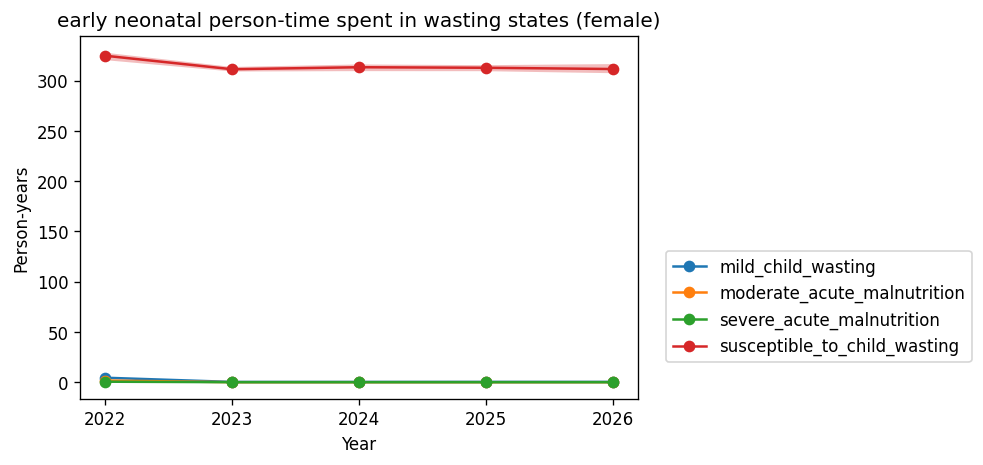

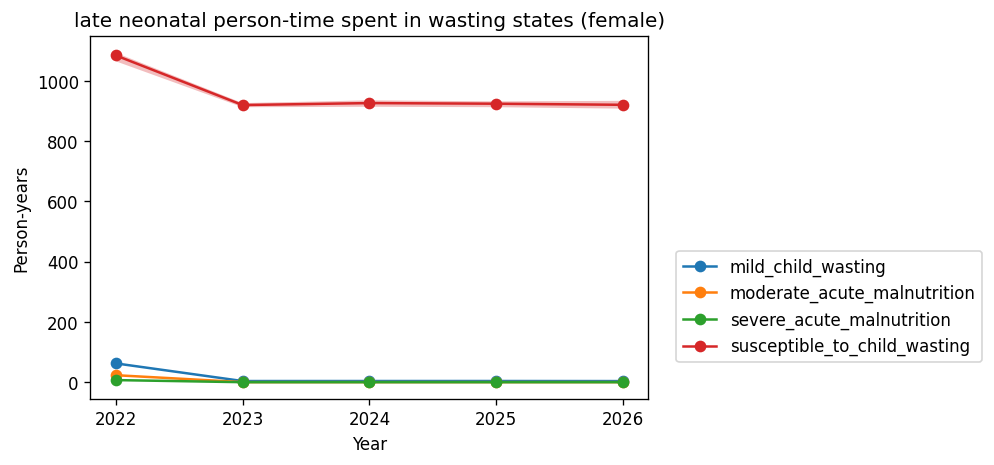

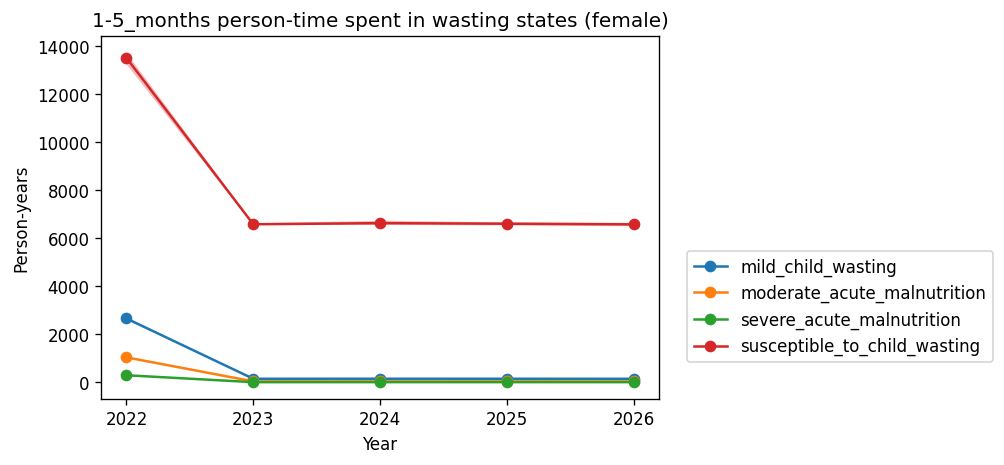

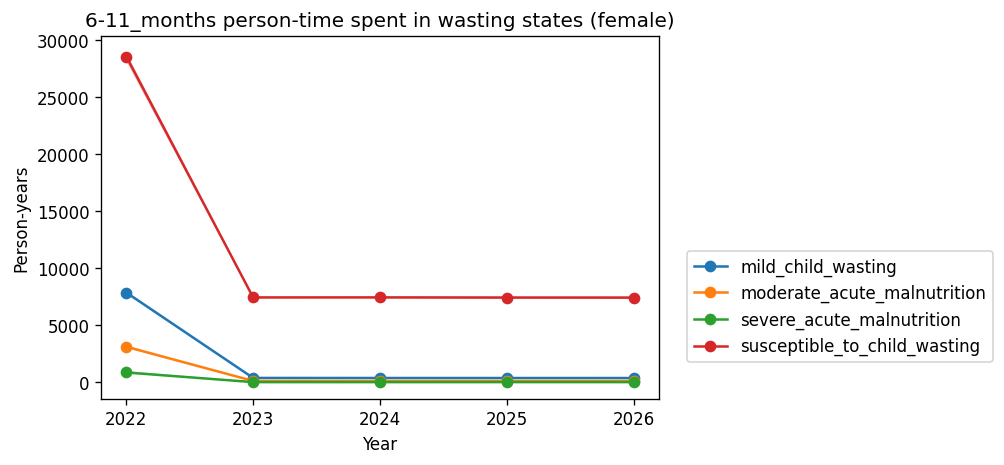

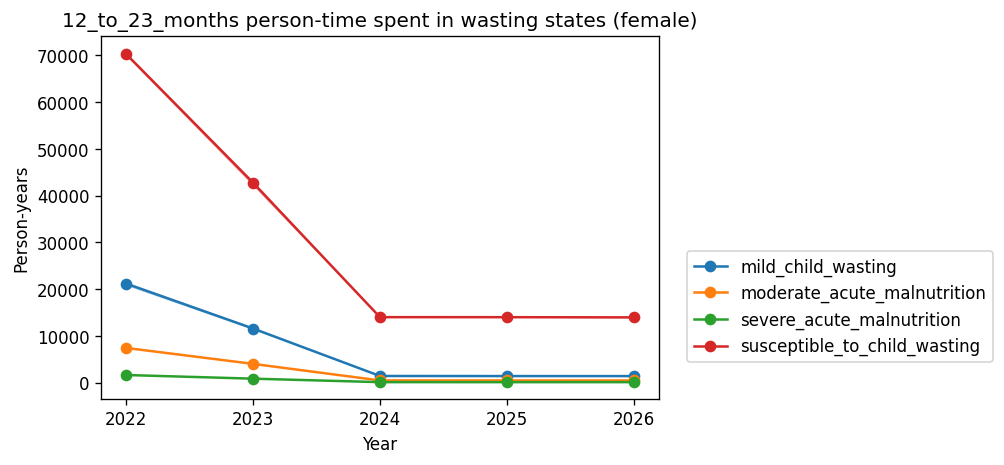

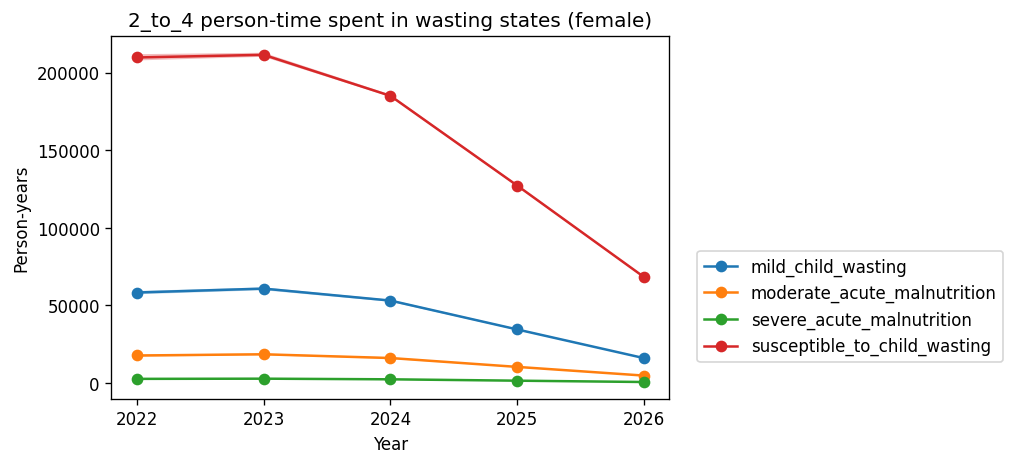

In [30]:
def plot_wasting_pt_over_time(df, sex, age_group):
    
    df.year = df.year.astype(int)
    state = df.cause.iloc[0]
    
    #{1: 'early_neonatal', 2: 'late_neonatal', 3: '1-5_months', 4: '6-11_months', 5: '12_to_23_months', 6:'2_to_4'}
    age_map = {1:'early neonatal',2:'late neonatal', 3: '1-5_months', 4: '6-11_months', 5: '12_to_23_months', 6:'2_to_4'}
    age = age_map[age_group]
    
    plt.figure(figsize=(6, 4), dpi=120)
    for cause in df.cause.unique():
        sub = df.loc[(df.sex==sex) & (df.age_group==age_group) & (df.cause==cause)]
        plt.plot(sub['year'], sub['mean'], marker='o', label=cause)
        plt.fill_between(sub['year'], sub['2.5%'], sub['97.5%'], alpha=.3)

    plt.legend(loc=(1.05, .1))
    plt.xlabel('Year')
    plt.ylabel('Person-years')
    plt.xticks(ticks = range(df.year.min(), df.year.max()+1))#, labels = ['early neonatal', 'late neonatal', 'post neonatal', '1 to 4'], rotation = 45) 
    plt.title(f'{age} person-time spent in wasting states ({sex})')

for age_group in pt_tmrel_wasting.age_group.unique():
    plot_wasting_pt_over_time(wasting_pt_df, sex = 'female', age_group = age_group)

In [31]:
def plot_sim_wasting(sim_data: pd.DataFrame, sex: str, sim_measure: str):
           
    ## add age label
    age_labels = {1:'early neonatal',2:'late neonatal', 3: '1-5_months', 4: '6-11_months', 5: '12_to_23_months', 6:'2_to_4'}
    sim_data['age_label'] = sim_data.age_group.map(age_labels)
    
    
    plt.figure(figsize=(6, 4), dpi=120)
    
    for year in sim_data.year.unique():
        sim_sub = sim_data[(sim_data.scenario == 'baseline') & 
                           (sim_data.year == year) & 
                           (sim_data.sex == sex)]
        plt.plot(sim_sub['age_group'], sim_sub['mean'], marker='o', label=year)
        plt.fill_between(sim_sub['age_group'], sim_sub['2.5%'], sim_sub['97.5%'], alpha=.3)
    
    plt.title(f'{sim_measure}, {sex}')
    plt.xlabel('Age')
    plt.xticks(ticks = [1, 2, 3, 4, 5, 6], labels = ['early neonatal', 'late neonatal', '1-5mo', '6-11mo', '1-2y', '2-4y'], rotation = 45)
          
    plt.legend(loc=(1.05, .1))
    plt.grid()
    

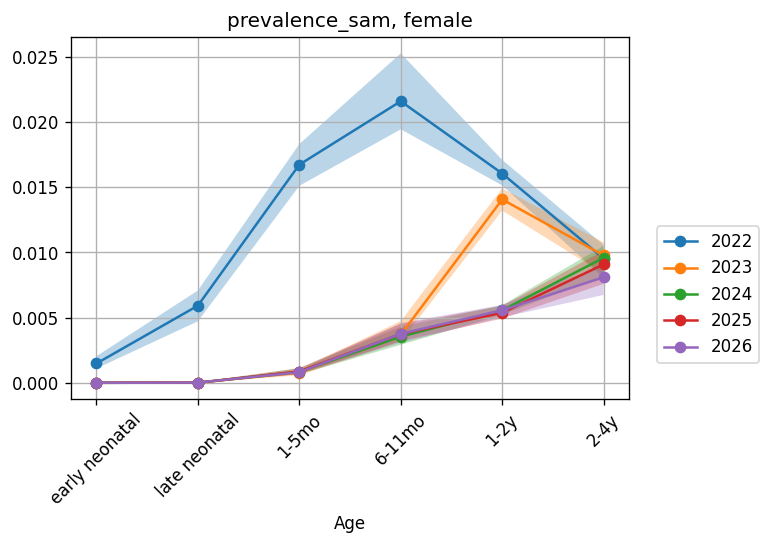

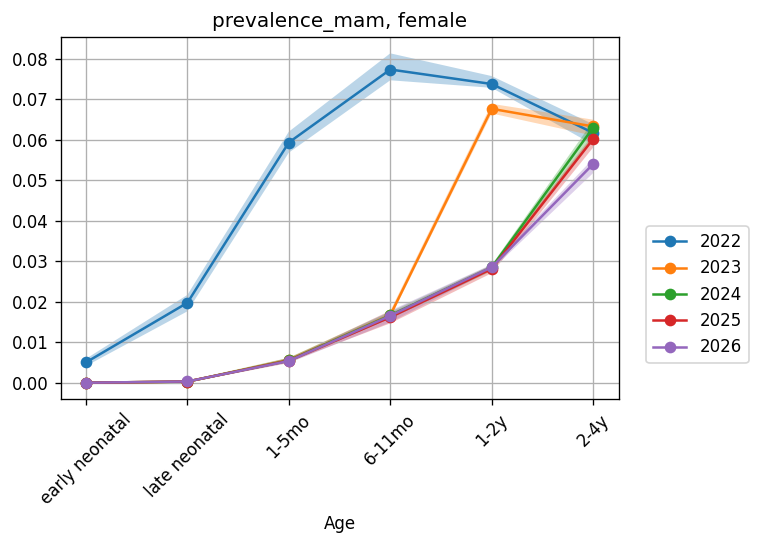

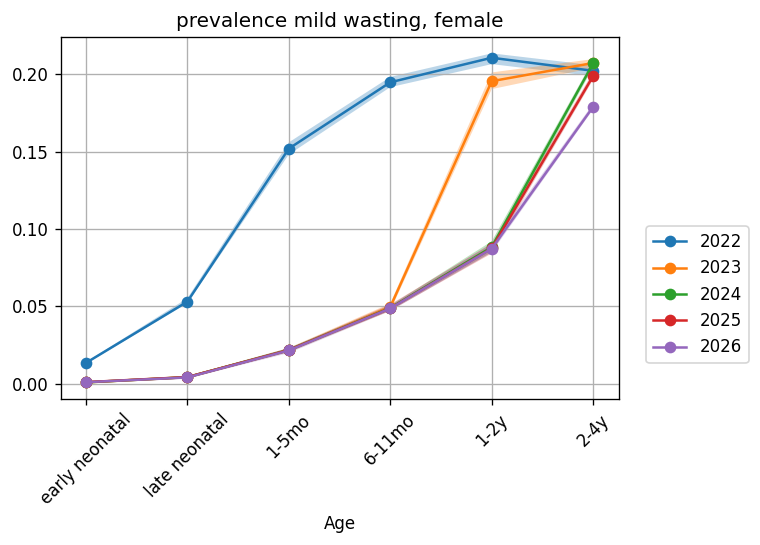

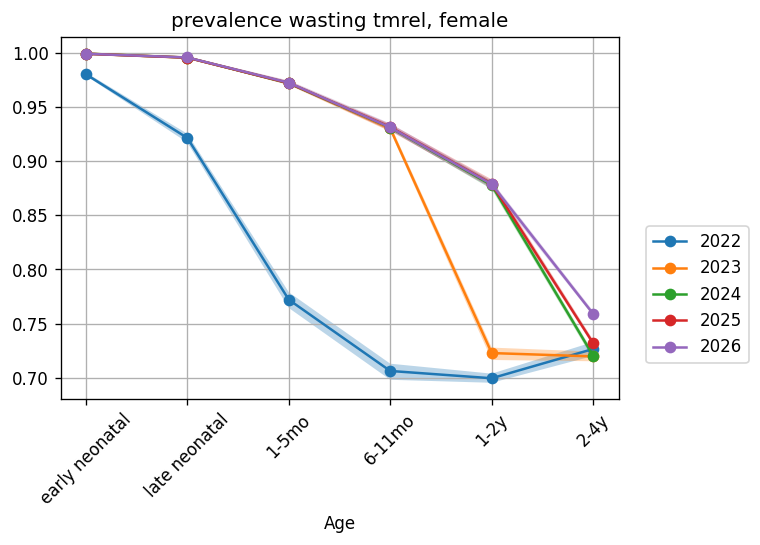

In [32]:
plot_sim_wasting(prevalence_sam, sex = 'female', sim_measure = 'prevalence_sam')
plot_sim_wasting(prevalence_mam, sex = 'female', sim_measure = 'prevalence_mam')
plot_sim_wasting(prevalence_mild, sex = 'female', sim_measure = 'prevalence mild wasting')
plot_sim_wasting(prevalence_wasting_tmrel, sex = 'female', sim_measure = 'prevalence wasting tmrel')

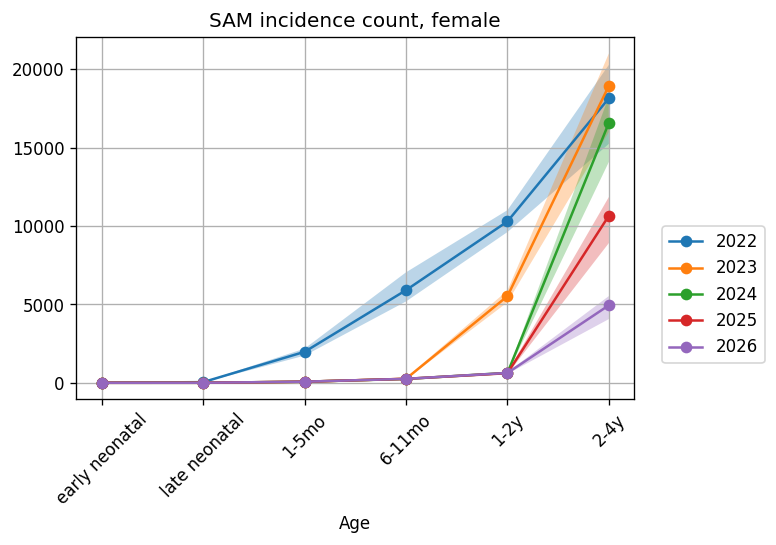

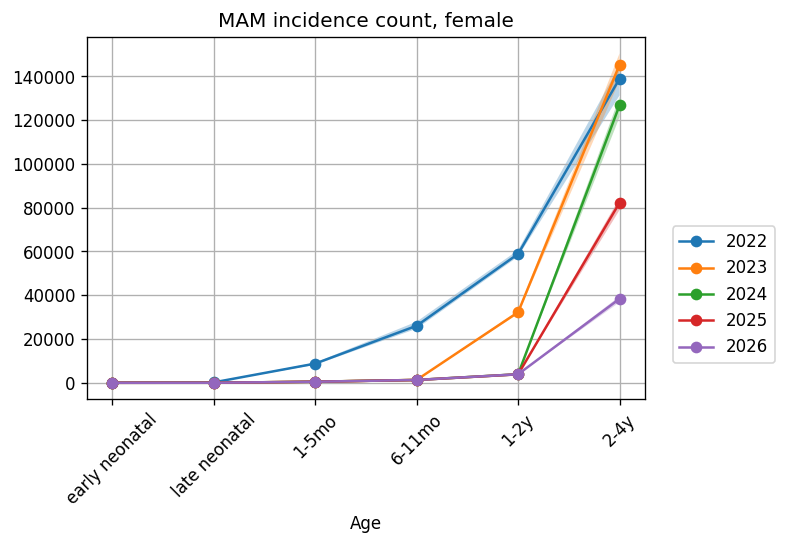

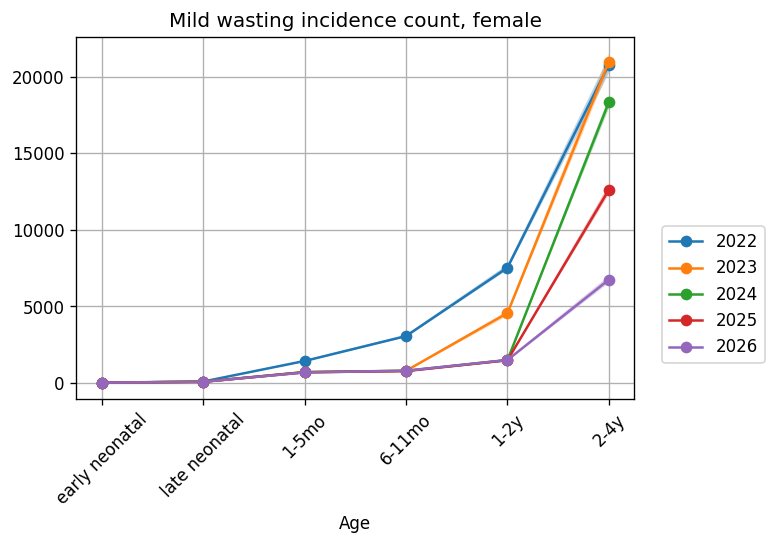

In [33]:
plot_sim_wasting(inc_count_sam, 'female', 'SAM incidence count')
plot_sim_wasting(inc_count_mam, 'female', 'MAM incidence count')
plot_sim_wasting(inc_count_mild, 'female', 'Mild wasting incidence count')

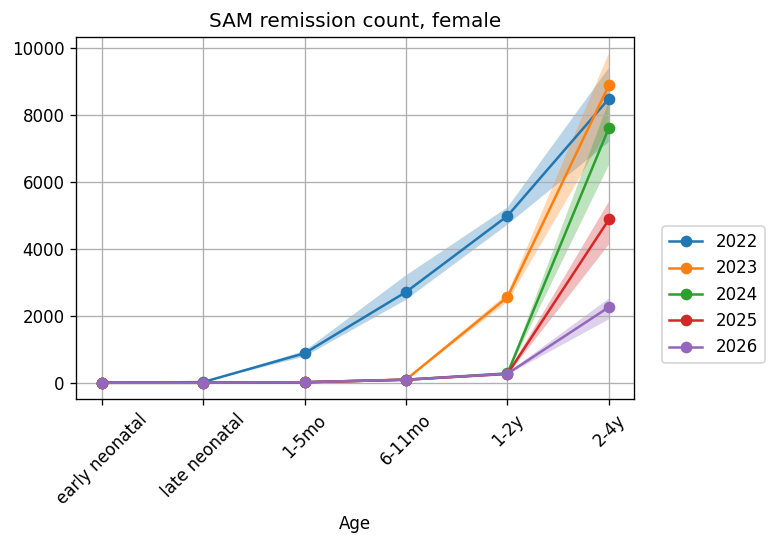

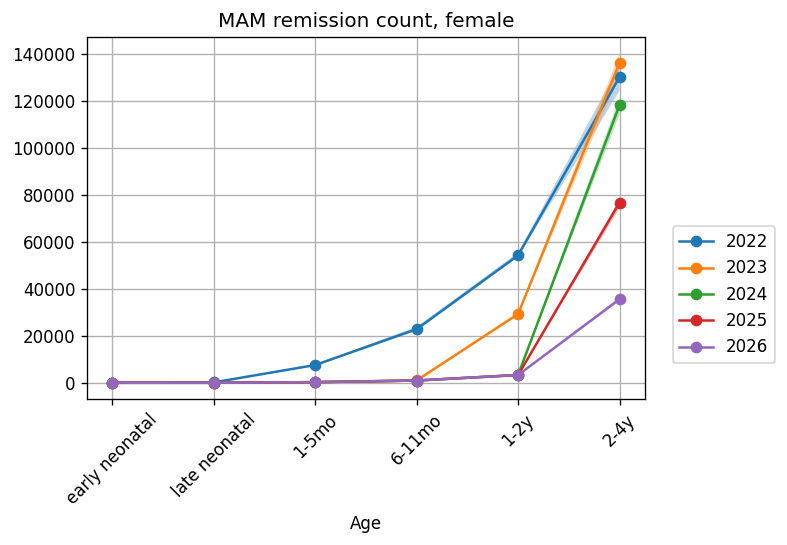

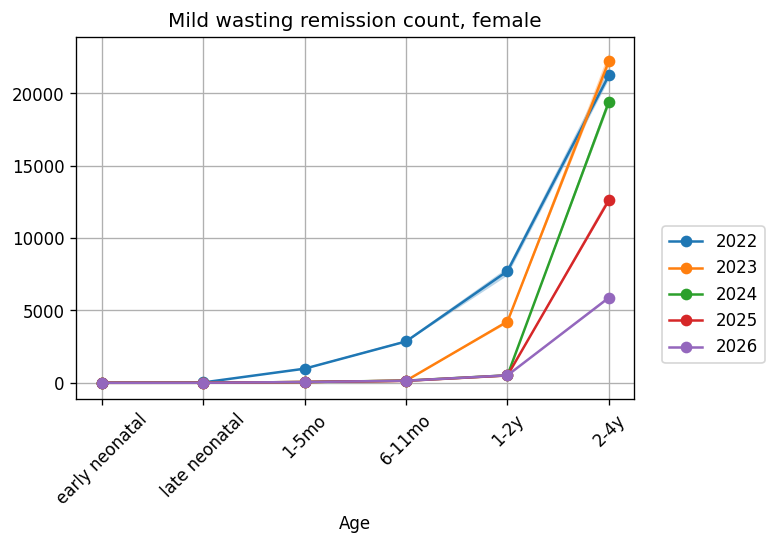

In [36]:
plot_sim_wasting(rem_count_sam, 'female', 'SAM remission count')
plot_sim_wasting(rem_count_mam, 'female', 'MAM remission count')
plot_sim_wasting(rem_count_mild, 'female', 'Mild wasting remission count')

In [56]:
art_wasting_prev.query("risk=='sam'")

,sex,age_start,age_end,year_start,year_end,mean,2.5%,97.5%,age,age_group,risk,measure
0,female,0.076712,0.5,2019,2020,0.024987,0.021183,0.028627,1-5_months,3,sam,prevalence
4,female,0.500000,1.0,2019,2020,0.025921,0.022489,0.029991,6-11_months,4,sam,prevalence
8,female,1.000000,2.0,2019,2020,0.017526,0.014464,0.020893,12_to_23_months,5,sam,prevalence
12,female,2.000000,5.0,2019,2020,0.010374,0.008191,0.012737,2_to_4,6,sam,prevalence
16,male,0.076712,0.5,2019,2020,0.040833,0.035179,0.046745,1-5_months,3,sam,prevalence
20,male,0.500000,1.0,2019,2020,0.038799,0.033571,0.044388,6-11_months,4,sam,prevalence
24,male,1.000000,2.0,2019,2020,0.028636,0.024285,0.032975,12_to_23_months,5,sam,prevalence
28,male,2.000000,5.0,2019,2020,0.016175,0.013549,0.018823,2_to_4,6,sam,prevalence


In [48]:
prevalence_sam

,age_group,sex,year,scenario,measure,cause,mean,2.5%,97.5%,age_label
0,1,female,2022,baseline,state_person_time,severe_acute_malnutrition,0.001481,0.001097,0.002041,early neonatal
1,1,female,2023,baseline,state_person_time,severe_acute_malnutrition,0.000000,0.000000,0.000000,early neonatal
2,1,female,2024,baseline,state_person_time,severe_acute_malnutrition,0.000000,0.000000,0.000000,early neonatal
3,1,female,2025,baseline,state_person_time,severe_acute_malnutrition,0.000000,0.000000,0.000000,early neonatal
...,...,...,...,...,...,...,...,...,...,...
56,6,male,2023,baseline,state_person_time,severe_acute_malnutrition,0.015546,0.013881,0.017051,2_to_4
57,6,male,2024,baseline,state_person_time,severe_acute_malnutrition,0.015150,0.013348,0.016684,2_to_4
58,6,male,2025,baseline,state_person_time,severe_acute_malnutrition,0.014451,0.012835,0.015800,2_to_4
59,6,male,2026,baseline,state_person_time,severe_acute_malnutrition,0.012749,0.011510,0.013771,2_to_4


In [57]:
prevalence_mam

,age_group,sex,year,scenario,measure,cause,mean,2.5%,97.5%,age_label
0,1,female,2022,baseline,state_person_time,moderate_acute_malnutrition,0.005026,0.004129,0.005911,early neonatal
1,1,female,2023,baseline,state_person_time,moderate_acute_malnutrition,0.000016,0.000000,0.000043,early neonatal
2,1,female,2024,baseline,state_person_time,moderate_acute_malnutrition,0.000023,0.000000,0.000062,early neonatal
3,1,female,2025,baseline,state_person_time,moderate_acute_malnutrition,0.000008,0.000000,0.000047,early neonatal
...,...,...,...,...,...,...,...,...,...,...
56,6,male,2023,baseline,state_person_time,moderate_acute_malnutrition,0.075649,0.073245,0.077844,2_to_4
57,6,male,2024,baseline,state_person_time,moderate_acute_malnutrition,0.075600,0.073532,0.077569,2_to_4
58,6,male,2025,baseline,state_person_time,moderate_acute_malnutrition,0.072253,0.070161,0.073961,2_to_4
59,6,male,2026,baseline,state_person_time,moderate_acute_malnutrition,0.064479,0.062362,0.066258,2_to_4


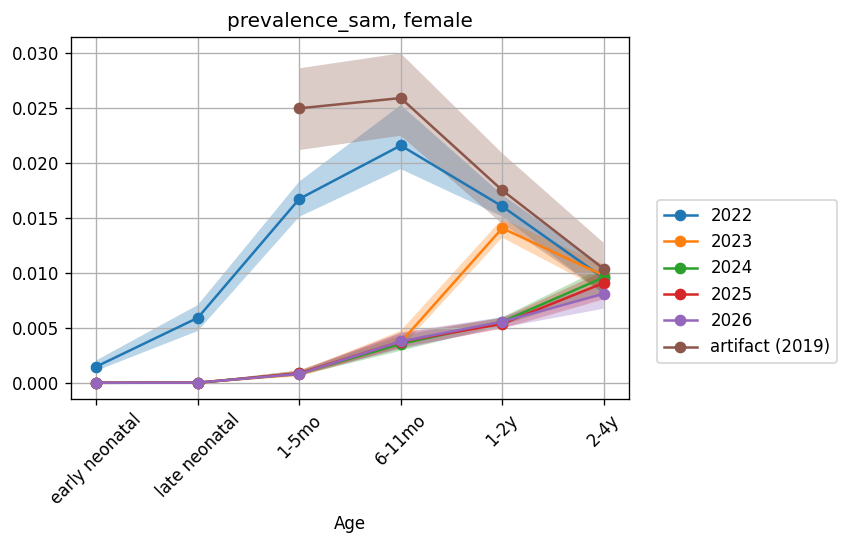

In [51]:
def plot_sim_vs_art_wasting(sim_data: pd.DataFrame, art_data: pd.DataFrame, sex: str, sim_measure: str):
           
    ## add age label
    age_labels = {1:'early neonatal',2:'late neonatal', 3: '1-5_months', 4: '6-11_months', 5: '12_to_23_months', 6:'2_to_4'}
    sim_data['age_label'] = sim_data.age_group.map(age_labels)
    
    
    plt.figure(figsize=(6, 4), dpi=120)
    
    for year in sim_data.year.unique():
        sim_sub = sim_data[(sim_data.scenario == 'baseline') & 
                           (sim_data.year == year) & 
                           (sim_data.sex == sex)]
        plt.plot(sim_sub['age_group'], sim_sub['mean'], marker='o', label=year)
        plt.fill_between(sim_sub['age_group'], sim_sub['2.5%'], sim_sub['97.5%'], alpha=.3)
        
    art_sub = art_data.query("sex==@sex")
    plt.plot(art_sub['age_group'], art_sub['mean'], marker='o', label="artifact (2019)")
    plt.fill_between(art_sub['age_group'], art_sub['2.5%'], art_sub['97.5%'], alpha=.3)
    
    plt.title(f'{sim_measure}, {sex}')
    plt.xlabel('Age')
    plt.xticks(ticks = [1, 2, 3, 4, 5, 6], labels = ['early neonatal', 'late neonatal', '1-5mo', '6-11mo', '1-2y', '2-4y'], rotation = 45)
          
    plt.legend(loc=(1.05, .1))
    plt.grid()

plot_sim_vs_art_wasting(prevalence_sam, wasting_prev.query("risk=='sam'"), sex = 'female', sim_measure = 'prevalence_sam')

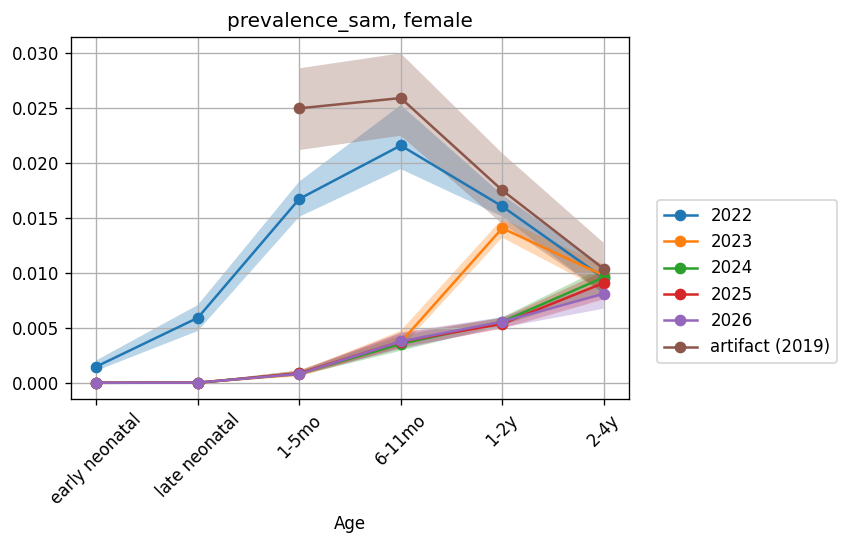

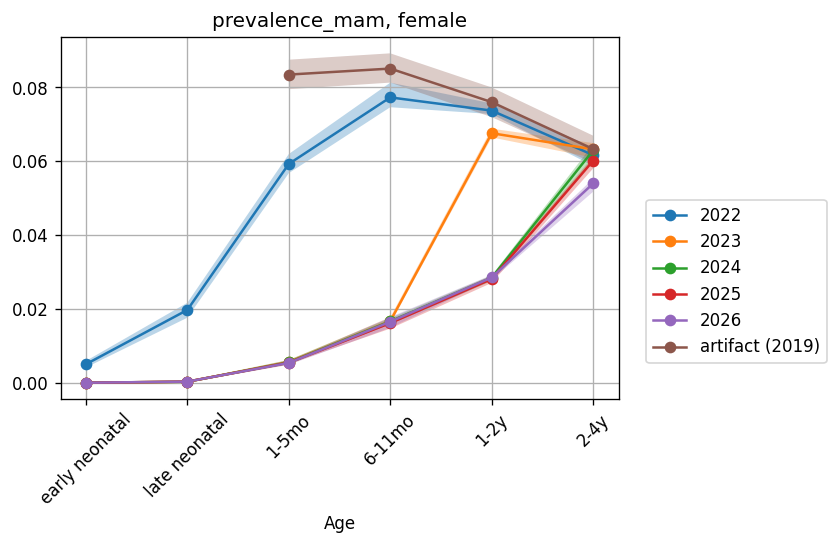

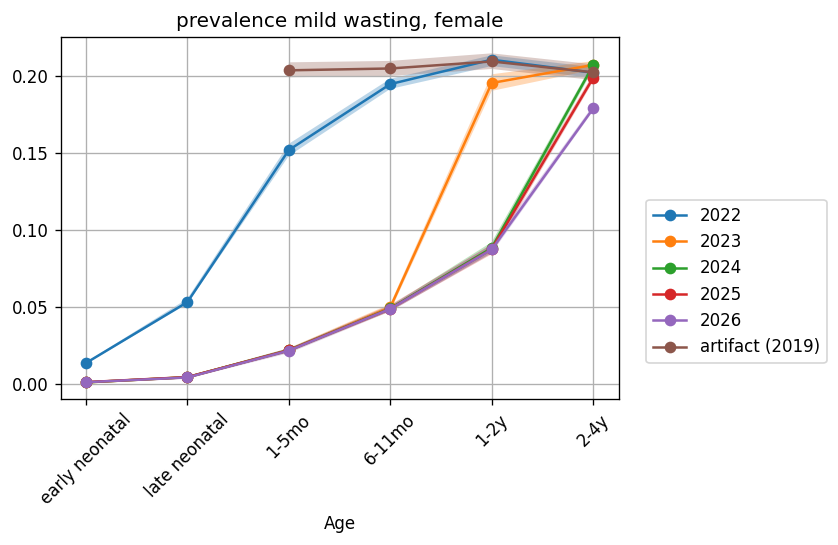

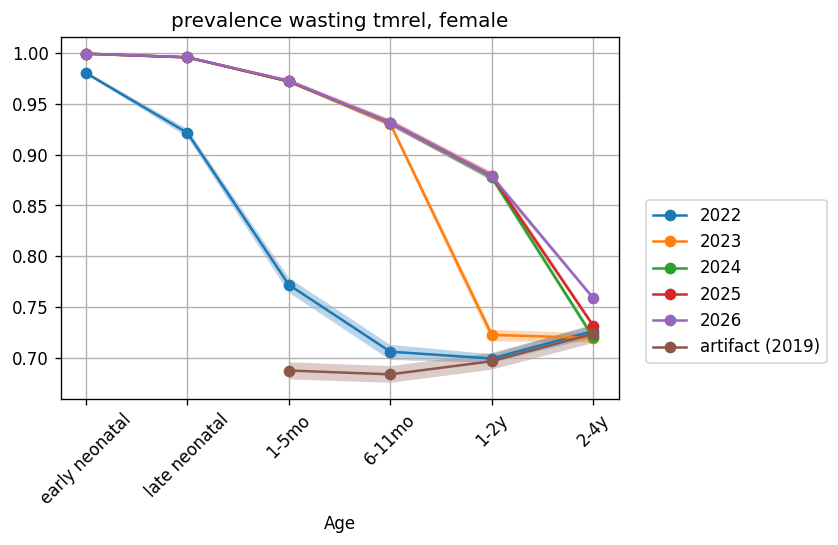

In [52]:
# plot_sim_vs_art_wasting(prevalence_sam, wasting_prev.query("risk=='sam'"), sex = 'female', sim_measure = 'prevalence_sam')
plot_sim_vs_art_wasting(prevalence_sam, sam_prev, sex = 'female', sim_measure = 'prevalence_sam')
plot_sim_vs_art_wasting(prevalence_mam, mam_prev, sex = 'female', sim_measure = 'prevalence_mam')
plot_sim_vs_art_wasting(prevalence_mild, mild_prev, sex = 'female', sim_measure = 'prevalence mild wasting')
plot_sim_vs_art_wasting(prevalence_wasting_tmrel, sus_wasting_prev, sex = 'female', sim_measure = 'prevalence wasting tmrel')

In [53]:
output_dir

'/share/scratch/users/ndbs/vivarium_results/ciff_malnutrition/verification_and_validation/v2.1_gbd_2020_wasting/'

In [54]:
ls /share/scratch/users/ndbs/vivarium_results/ciff_malnutrition/verification_and_validation/v2.1_gbd_2020_wasting/

all_cause_mortality.pdf  diarrhea_remission.pdf  lri_remission.pdf
diarrhea_emr.pdf         lri_emr.pdf             measles_emr.pdf
diarrhea_incidence.pdf   lri_incidence.pdf       measles_incidence.pdf
diarrhea_mortality.pdf   lri_mortality.pdf       measles_mortality.pdf
diarrhea_prevalence.pdf  lri_prevalence.pdf      measles_prevalence.pdf


In [65]:
art_wasting_prev['risk'].unique()

array(['sam', 'mam', 'mild_wasting', 'tmrel_wasting'], dtype=object)

In [64]:
sim_wasting_prev = (
    pd.concat([prevalence_sam, prevalence_mam, prevalence_mild, prevalence_wasting_tmrel], ignore_index=True)
    .assign(
        risk=lambda df: df['cause'].map(
            {'severe_acute_malnutrition': 'sam',
             'moderate_acute_malnutrition': 'mam',
             'mild_child_wasting': 'mild_wasting',
             'susceptible_to_child_wasting': 'tmrel_wasting'
            })
           )
)
sim_wasting_prev

,age_group,sex,year,scenario,measure,cause,mean,2.5%,97.5%,age_label,risk
0,1,female,2022,baseline,state_person_time,severe_acute_malnutrition,0.001481,0.001097,0.002041,early neonatal,sam
1,1,female,2023,baseline,state_person_time,severe_acute_malnutrition,0.000000,0.000000,0.000000,early neonatal,sam
2,1,female,2024,baseline,state_person_time,severe_acute_malnutrition,0.000000,0.000000,0.000000,early neonatal,sam
3,1,female,2025,baseline,state_person_time,severe_acute_malnutrition,0.000000,0.000000,0.000000,early neonatal,sam
...,...,...,...,...,...,...,...,...,...,...,...
236,6,male,2023,baseline,state_person_time,susceptible_to_child_wasting,0.687361,0.681878,0.691005,2_to_4,tmrel_wasting
237,6,male,2024,baseline,state_person_time,susceptible_to_child_wasting,0.686920,0.683030,0.690247,2_to_4,tmrel_wasting
238,6,male,2025,baseline,state_person_time,susceptible_to_child_wasting,0.700214,0.696431,0.702821,2_to_4,tmrel_wasting
239,6,male,2026,baseline,state_person_time,susceptible_to_child_wasting,0.731651,0.728662,0.735236,2_to_4,tmrel_wasting


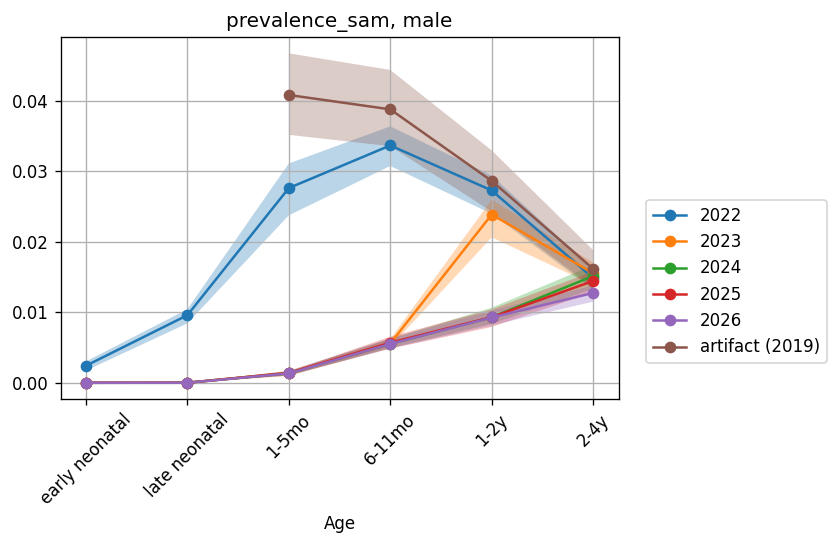

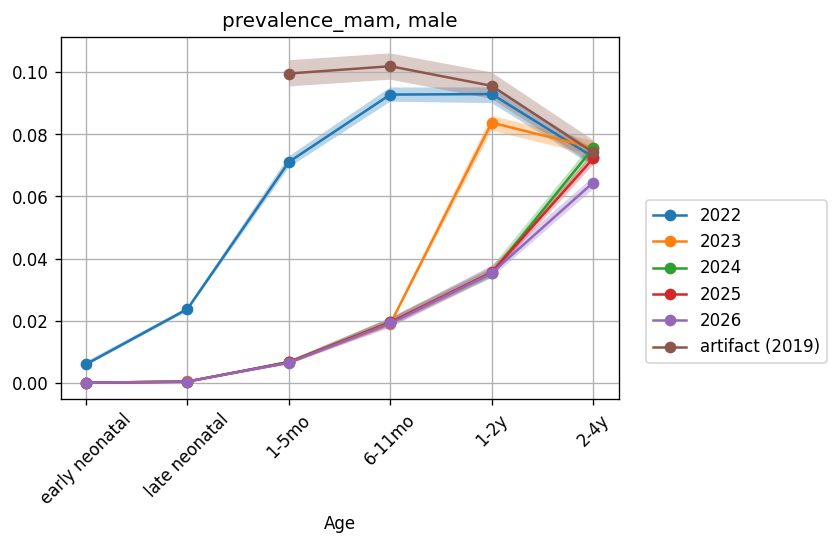

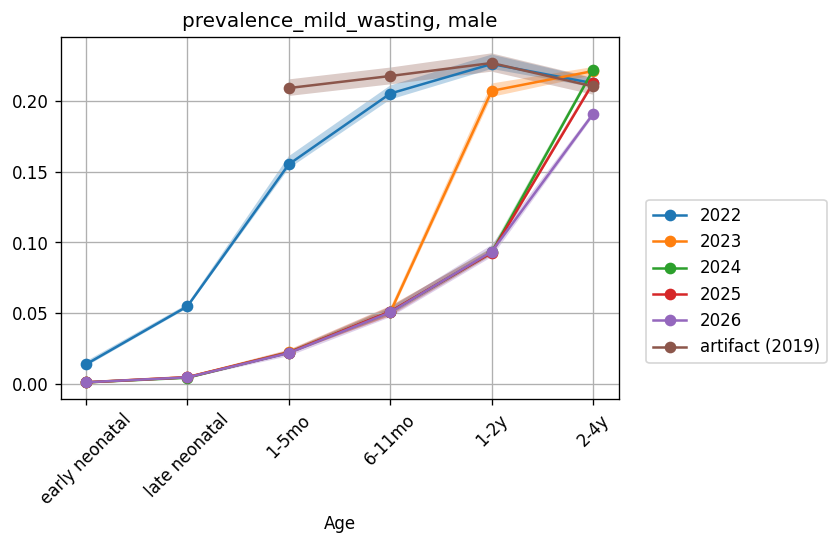

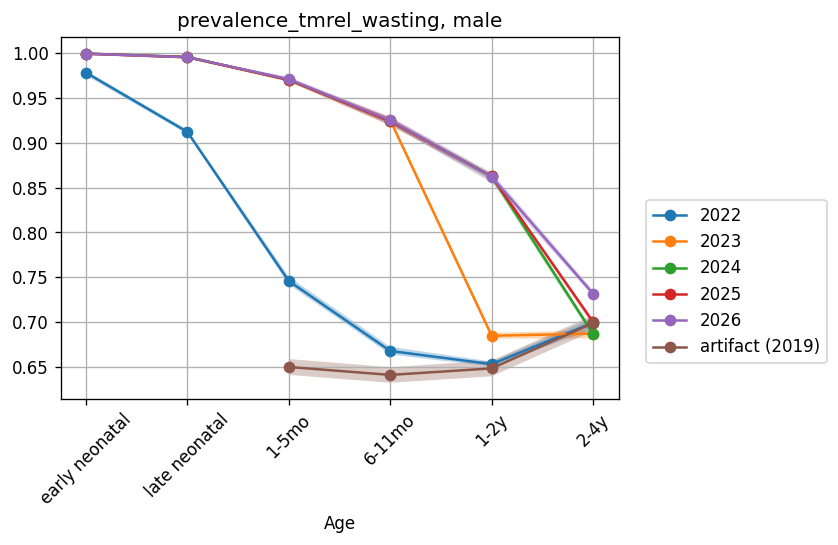

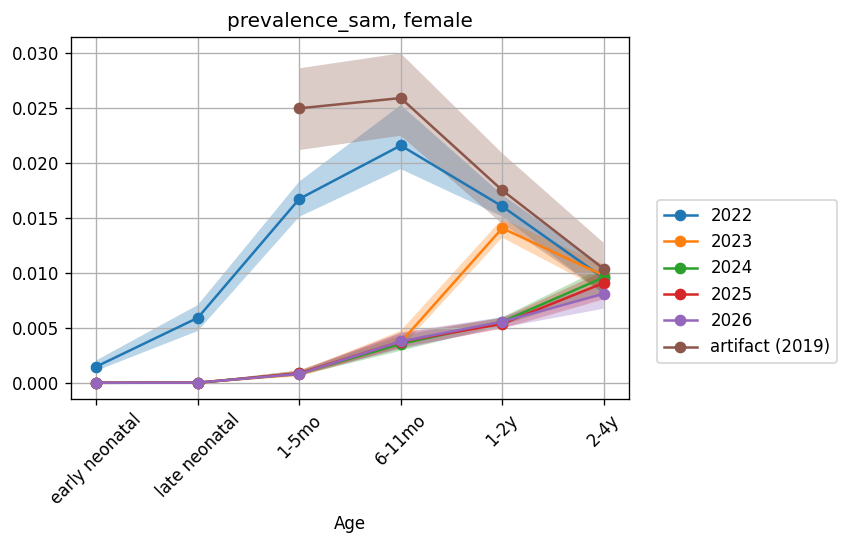

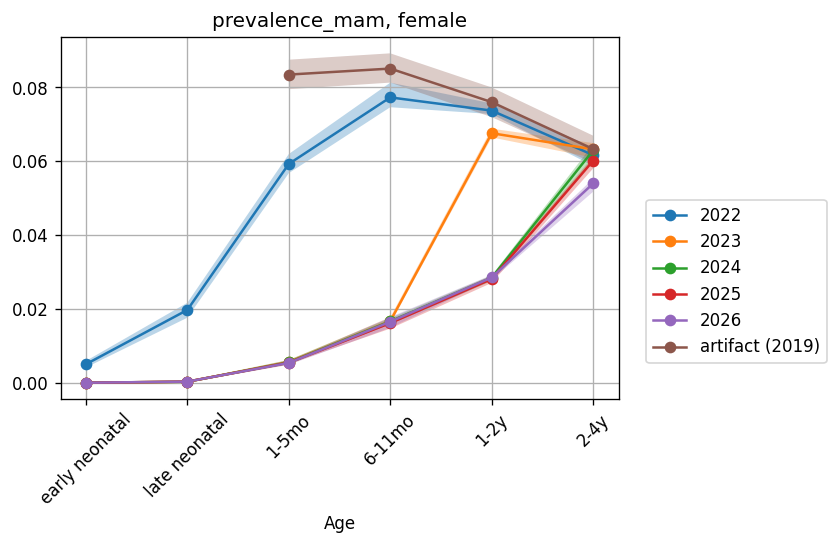

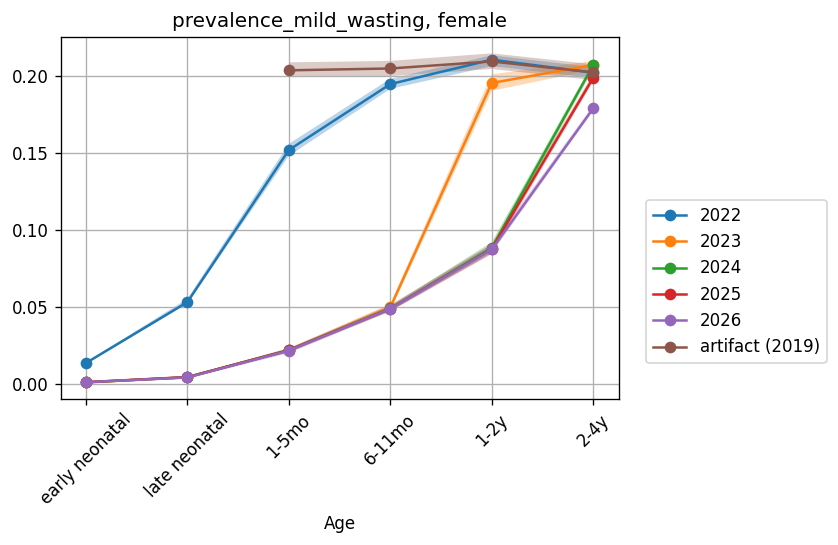

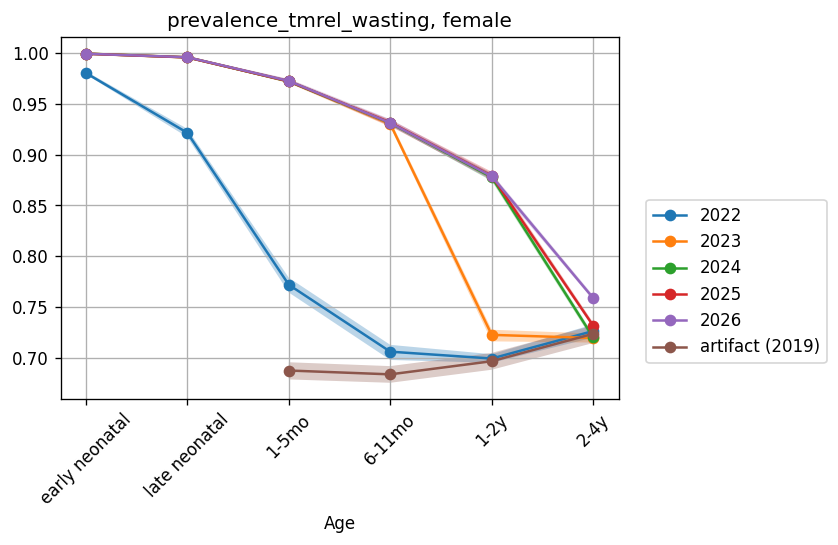

In [68]:
with PdfPages(output_dir + 'wasting_prevalence.pdf') as pdf:
    for sex in ('male', 'female'):
        for risk_cat in ('sam', 'mam', 'mild_wasting', 'tmrel_wasting'):
            plot_sim_vs_art_wasting(
                sim_wasting_prev.query('risk==@risk_cat'),
                art_wasting_prev.query('risk==@risk_cat'),
                sex = sex,
                sim_measure = f'prevalence_{risk_cat}'
            )
            pdf.savefig(bbox_inches='tight')

In [69]:
ls /share/scratch/users/ndbs/vivarium_results/ciff_malnutrition/verification_and_validation/v2.1_gbd_2020_wasting/

all_cause_mortality.pdf  lri_emr.pdf         measles_incidence.pdf
diarrhea_emr.pdf         lri_incidence.pdf   measles_mortality.pdf
diarrhea_incidence.pdf   lri_mortality.pdf   measles_prevalence.pdf
diarrhea_mortality.pdf   lri_prevalence.pdf  wasting_prevalence.pdf
diarrhea_prevalence.pdf  lri_remission.pdf
diarrhea_remission.pdf   measles_emr.pdf
